# Model: Log Firing rates with ADVI

- spike counts are poisson distributed
- firing rates are log-Normally distributed
- firing rates are covariant across units
- noise is also covariant

That is, we want to make the model

$$\begin{align}
N_{tu} &\sim \mathrm{Poisson}(e^{\eta_{tu}}) \\
\eta_{t\cdot} &\sim \mathcal{N}(a_\cdot, S_\eta) \\
a_u &\sim \mathcal{N}(\mu_a, \Sigma_a) \\
S_\eta &\sim \text{Inv-Wishart}(\nu_\eta, \Psi_\eta)
\end{align}$$

In [1]:
using Distributions
using PyPlot
using ForwardDiff
using VinDsl
srand(12345);

/Users/jmxp/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Set up some parameters

In [2]:
T = 1000  # number of time steps
U = 10  # units

10

# Make firing rates

In [3]:
baseline = 10.
baseline_sd = 0.10
log_bl = log(baseline)
unit_bl = log_bl + baseline_sd * randn(U);

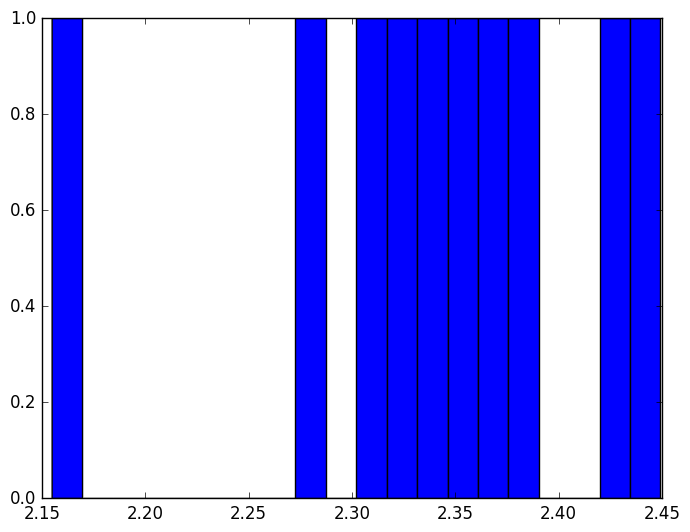

In [4]:
PyPlot.plt[:hist](unit_bl, 20);

In [5]:
fr_log = unit_bl' .+ zeros(T, U)  # firing rate

# make a tridiagonal covariance matrix
Ση = MvNormal(full(SymTridiagonal(ones(U), 0.2 * ones(U - 1))))

eta = fr_log + 0.1 * rand(Ση, T)'
fr = exp(eta);

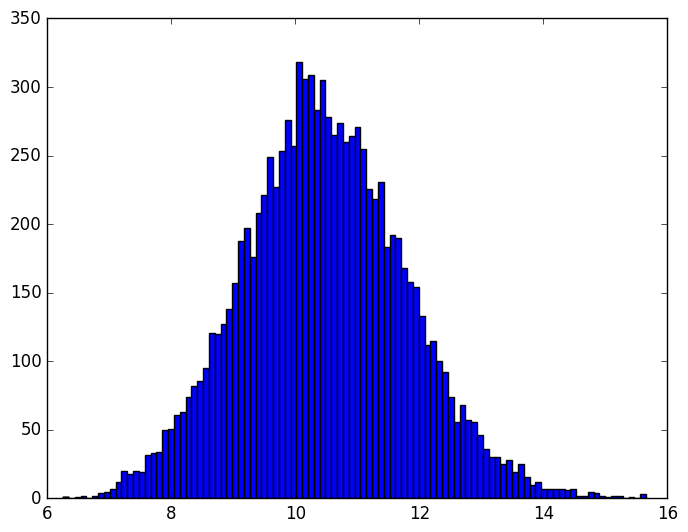

In [6]:
PyPlot.plt[:hist](fr[:], 100);

# Make spikes

In [7]:
spikes = Array{Int}(size(fr)...)
for i in eachindex(fr)
    spikes[i] = rand(Poisson(fr[i]))
end

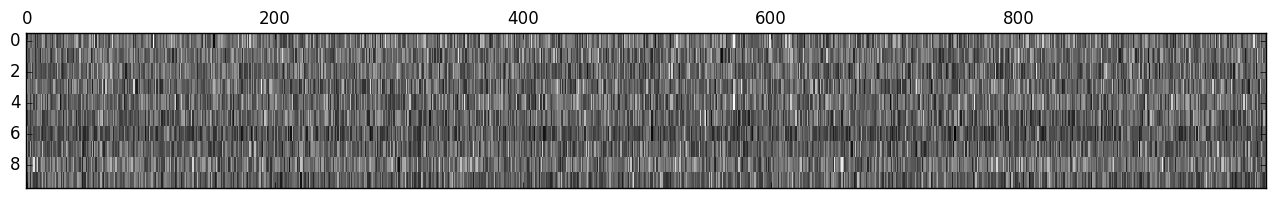

In [8]:
matshow(spikes', aspect="auto", cmap="gray");

# Fleshing out the model:

## Data:
- $N$

## Parameters:
- $\eta$
- $a$ 
- $S$

## Priors:
- $a_u \sim \mathcal{N}(\log(15), 0.1^2)$ (but we want posterior over $a$ to be MvNormal
- $S \sim \text{Inv-Wishart}(U, \mathbb{1}_{U \times U})$

In [11]:
function ELBO(x::Vector)
    ctr = 1
    L = zero(eltype(x))
    
    @advi_declarations begin
        a::Real()[U]
        S::CovMat(U)
        η::RealVec(U)[T]    
    end
    
    ########## E[log p]
    for u in 1:U
        L += logpdf(Normal(log(15.), 0.1), a[u])
    end
    L += logpdf(InverseWishart(U, eye(U)), S)
    for t in 1:T
        for u in 1:U
            L += logpdf(Poisson(exp(η[t][u])), spikes[t, u])
        end
    end
    
    L
end

ELBO (generic function with 1 method)

In [12]:
npars = U * VinDsl.num_pars_advi(RReal()) + VinDsl.num_pars_advi(RCovMat(U)) +
T * VinDsl.num_pars_advi(RRealVec(U))
xx = 0.1 * randn(npars)
ELBO(xx)

-172796.1518362259

In [15]:
∇L = (storage, x) -> ForwardDiff.gradient!(storage, ELBO, x)

(anonymous function)

In [16]:
stor = similar(xx)
∇L(stor, xx)

20130-element Array{Float64,1}:
 302.684   
 -39.0358  
 221.276   
 101.422   
 284.617   
 -40.9675  
 156.693   
 187.883   
 261.503   
  59.0891  
  83.1857  
 165.997   
 319.943   
   ⋮       
  10.9585  
   7.64507 
   5.96391 
   2.86289 
  -1.81848 
  -3.33408 
  -1.97074 
  -0.327695
  -6.20405 
  14.7903  
   0.700619
  -2.32479 

In [17]:
stor = similar(xx)
yy = copy(xx)
@time @profile ∇L(stor, yy)
#Profile.print()

 50.368151 seconds (182.11 M allocations: 27.367 GB, 5.55% gc time)


20130-element Array{Float64,1}:
  250.737   
   97.9996  
  204.179   
  128.533   
  178.075   
  164.28    
  139.292   
  191.312   
  390.156   
 -414.037   
  482.816   
 -968.425   
  196.844   
    ⋮       
   10.6792  
    7.65086 
  -16.0406  
  -16.5243  
   12.1565  
    5.6099  
    5.92308 
   -0.42114 
   -0.418602
   -7.63236 
   -8.26516 
    2.40584 

In [21]:
stor = similar(xx)
yy = copy(xx)
@time ∇L(stor, yy)
#Profile.print()

 48.528979 seconds (211.82 M allocations: 35.263 GB, 6.61% gc time)


20130-element Array{Float64,1}:
  112.689   
  148.616   
  214.532   
  106.602   
  356.776   
 -319.006   
  330.402   
 -241.958   
   94.8451  
  161.058   
  287.778   
  -77.8113  
  228.628   
    ⋮       
    6.17156 
    7.90104 
    4.48699 
   19.2151  
   10.3063  
    4.47824 
   -6.23559 
    3.31081 
  -18.533   
   -3.91601 
  -13.1217  
    0.916936

In [18]:
Profile.print(format=:flat, sortedby=:count)

 Count File                       Function                                 Line
     1 ./array.jl                 fill!                                     197
     1 ./essentials.jl            append_any                                128
     1 ./essentials.jl            append_any                                133
     1 ./essentials.jl            append_any                                136
     1 ./grisu.jl                 grisu                                      46
     1 ./grisu/fastfixed.jl       fastfixedtoa                              233
     1 ./grisu/fastfixed.jl       filldigits32                               44
     1 ./hashing.jl               hash_64_64                                 18
     1 ./hashing.jl               hash_64_64                                 19
     1 ./hashing.jl               hash_64_64                                 21
     1 ./range.jl                 steprange_last                             54
     1 ./unicode/utf8.jl          string

In [14]:
yy = copy(xx)
gg = similar(yy)
avg_sq_grad = similar(gg)
firstpass = true
elbo = Float64[]

LoadError: LoadError: UndefVarError: xx not defined
while loading In[14], in expression starting on line 1

In [23]:
step_size = 0.1
decay = 0.9
eps = 1e-8
nsteps = 200

for jj in 1:nsteps
    ∇L(gg, yy)
    if firstpass == false
        avg_sq_grad = avg_sq_grad * decay + gg.^2 * (1 - decay)
    else
        avg_sq_grad = gg.^2
        firstpass = false
    end
    yy += step_size * gg ./(sqrt(avg_sq_grad) + eps)
    push!(elbo, ELBO(yy))
    display("Iteration $(length(elbo)) $(elbo[end])")
end

"Iteration 1 -165484.7771720721"

"Iteration 2 -1.50741953243046e9"

"Iteration 3 -148983.11711202847"

"Iteration 4 -145679.60645302437"

"Iteration 5 -137728.6891578564"

"Iteration 6 -130381.36524732958"

"Iteration 7 -120499.50871552966"

"Iteration 8 -113124.0643053376"

"Iteration 9 -108041.29990224743"

"Iteration 10 -101434.74776682627"

"Iteration 11 -96358.03947661593"

"Iteration 12 -90893.39722831872"

"Iteration 13 -84659.70802344159"

"Iteration 14 -79501.70681011457"

"Iteration 15 -75336.84859083773"

"Iteration 16 -72721.010345735"

"Iteration 17 -68160.75856971637"

"Iteration 18 -63702.042242816344"

"Iteration 19 -59182.04030949639"

"Iteration 20 -56303.660535955314"

"Iteration 21 -52380.07735567819"

"Iteration 22 -50447.69520608194"

"Iteration 23 -48053.22351273034"

"Iteration 24 -46345.81797133451"

"Iteration 25 -44473.31750298987"

"Iteration 26 -41498.129219502596"

"Iteration 27 -39659.879897641695"

"Iteration 28 -38506.337981709185"

"Iteration 29 -37901.360442767356"

"Iteration 30 -35691.596620079654"

"Iteration 31 -33908.360926702604"

"Iteration 32 -33388.626614537694"

"Iteration 33 -32297.025626170987"

"Iteration 34 -31867.073183901877"

"Iteration 35 -30997.024542979976"

"Iteration 36 -30667.575046162096"

"Iteration 37 -29875.23190856211"

"Iteration 38 -29067.158300421685"

"Iteration 39 -28699.239649149906"

"Iteration 40 -28704.900103473552"

"Iteration 41 -27857.700563252176"

"Iteration 42 -27877.94340652533"

"Iteration 43 -27740.084889127993"

"Iteration 44 -27189.907635626398"

"Iteration 45 -26890.44269756584"

"Iteration 46 -26591.81749523182"

"Iteration 47 -26832.35741029266"

"Iteration 48 -26180.353537004557"

"Iteration 49 -26286.508907506726"

"Iteration 50 -25986.24381975442"

"Iteration 51 -25714.036847848947"

"Iteration 52 -25382.49674040691"

"Iteration 53 -25639.812114022283"

"Iteration 54 -25256.124292254786"

"Iteration 55 -25797.242666916798"

"Iteration 56 -24974.610960542534"

"Iteration 57 -24997.888278457154"

"Iteration 58 -25114.943671176105"

"Iteration 59 -25173.714037184047"

"Iteration 60 -25027.93414129943"

"Iteration 61 -25153.949356177167"

"Iteration 62 -24951.61453744112"

"Iteration 63 -24552.67092107759"

"Iteration 64 -24442.411387923526"

"Iteration 65 -24792.32129420653"

"Iteration 66 -24689.65934420979"

"Iteration 67 -24721.237991757065"

"Iteration 68 -24623.737600372137"

"Iteration 69 -24608.64468502934"

"Iteration 70 -24737.9229558753"

"Iteration 71 -24330.427128657768"

"Iteration 72 -24626.773286471085"

"Iteration 73 -24632.02389649586"

"Iteration 74 -24286.853844133853"

"Iteration 75 -24481.13330605365"

"Iteration 76 -24430.791077951537"

"Iteration 77 -24481.047322814065"

"Iteration 78 -24405.71167535231"

"Iteration 79 -24930.33427238369"

"Iteration 80 -24521.67981071314"

"Iteration 81 -24261.302398879026"

"Iteration 82 -24471.044929130116"

LoadError: LoadError: InterruptException:
while loading In[23], in expression starting on line 6

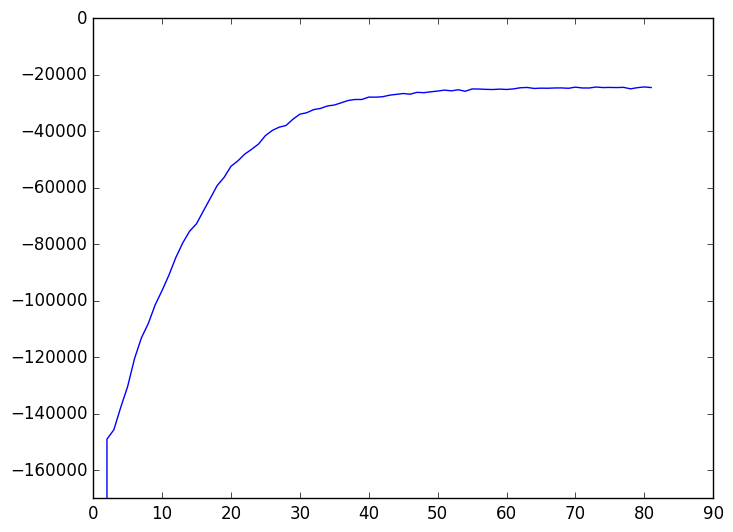

(-170000,0)

In [28]:
plot(elbo)
ylim(-170000, 0)

In [29]:
unit_bl

10-element Array{Float64,1}:
 2.41982
 2.38786
 2.34414
 2.35423
 2.37116
 2.33081
 2.15488
 2.31526
 2.44923
 2.28677

In [30]:
yy[1:2:20]

10-element Array{Float64,1}:
 2.91538
 2.67399
 2.72302
 2.67405
 2.73146
 2.68792
 2.74393
 2.76845
 2.73165
 2.76666

In [31]:
exp(yy[2:2:20])

10-element Array{Float64,1}:
 0.2226  
 0.168821
 0.188767
 0.133385
 0.213639
 0.145906
 0.165139
 0.161354
 0.140502
 0.170247

In [13]:
ex = :(begin
a::RealVec(K)[P, Q]
b::Real()[5, H]
c::Foo(5)
d::Bar
end
)

quote  # In[13], line 2:
    a::(RealVec(K))[P,Q] # In[13], line 3:
    b::(Real())[5,H] # In[13], line 4:
    c::Foo(5) # In[13], line 5:
    d::Bar
end

In [14]:
xdump(ex)

Expr 
  head: Symbol block
  args: Array(Any,(8,))
    1: LineNumberNode 
      file: Symbol In[13]
      line: Int64 2
    2: Expr 
      head: Symbol ::
      args: Array(Any,(2,))
        1: Symbol a
        2: Expr 
          head: Symbol ref
          args: Array(Any,(3,))
          typ: Any::DataType  <: Any
      typ: Any::DataType  <: Any
    3: LineNumberNode 
      file: Symbol In[13]
      line: Int64 3
    4: Expr 
      head: Symbol ::
      args: Array(Any,(2,))
        1: Symbol b
        2: Expr 
          head: Symbol ref
          args: Array(Any,(3,))
          typ: Any::DataType  <: Any
      typ: Any::DataType  <: Any
    5: LineNumberNode 
      file: Symbol In[13]
      line: Int64 4
    6: Expr 
      head: Symbol ::
      args: Array(Any,(2,))
        1: Symbol c
        2: Expr 
          head: Symbol call
          args: Array(Any,(2,))
          typ: Any::DataType  <: Any
      typ: Any::DataType  <: Any
    7: LineNumberNode 
      file: Symbol In[13]
     

In [23]:
ex.args[2].args[2].args[1].args[1]

:RealVec

In [21]:
ex.args[6].args[2]

:(Foo(5))

In [40]:
function _declarations(ex::Expr, vars)
    if ex.head == :(::)
        vname = ex.args[1]
        ζ_name = Symbol("ζ_", vname)
        T_name = Symbol("T_", vname)
        typearg = ex.args[2]
        if isa(typearg, Expr)
            if typearg.head == :ref   # array of variables
                T = Symbol("R", typearg.args[1])
                dims = typearg.args[2:end]
                d_expr = :(
                begin 
                    ΔL, ctr, $vname = VinDsl.advi_variable(x, ctr, $T, Tuple($(dims...)))
                    L += ΔL
                end
                    )
                else  # single variable
                T = Symbol("R", typearg)
                d_expr = :(
                begin
                    ΔL, ctr, $vname = VinDsl.advi_variable(x, ctr, $T)
                    L += ΔL
                end
                    )
            end
            push!(vars, d_expr)
        end       
        
    else
        for a in filter(x -> isa(x, Expr), ex.args)
            _declarations(a, vars)
        end
    end
    vars    
end

_declarations(ex::Expr) = _declarations(ex, [])

_declarations (generic function with 2 methods)

In [41]:
_declarations(ex)

3-element Array{Any,1}:
 quote  # In[40], line 13:
    (ΔL,ctr,a) = VinDsl.advi_variable(x,ctr,RRealVec(K),Tuple(P,Q)) # In[40], line 14:
    L += ΔL
end
 quote  # In[40], line 13:
    (ΔL,ctr,b) = VinDsl.advi_variable(x,ctr,RReal(),Tuple(5,H)) # In[40], line 14:
    L += ΔL
end    
 quote  # In[40], line 21:
    (ΔL,ctr,c) = VinDsl.advi_variable(x,ctr,RFoo(5)) # In[40], line 22:
    L += ΔL
end               